## imports, settings and functions

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Lasso, LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


In [59]:
# all functions

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    numeric_cols = dataframe.select_dtypes(include=['number'])
    if not numeric_cols.empty:
        print("##################### Quantiles #####################")
        print(numeric_cols.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
        car_th: int, optinal

    Returns
    ------
        cat_cols: list
        num_cols: list
        cat_but_car: list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = Total number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


## Exploratory Data Analysis ##

In [60]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [61]:
check_df(df)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [63]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


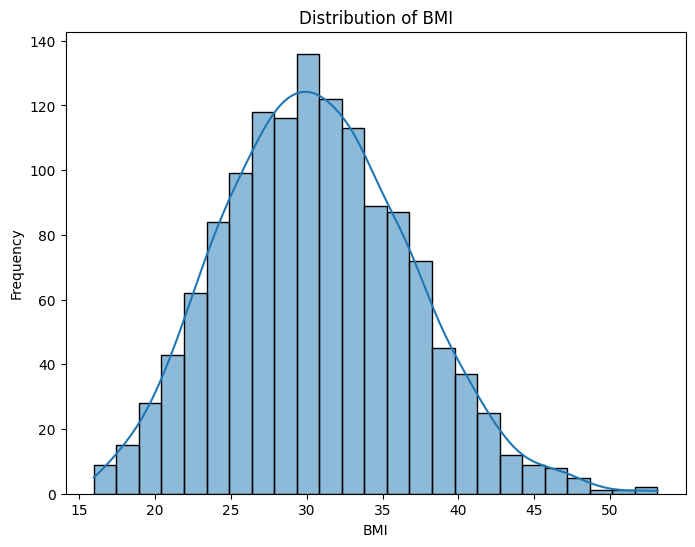

In [64]:
plt.figure(figsize=(8, 6))
sns.histplot(df['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# There doesn't seem to be any issue with the BMI distribution; we can observe an increase in frequency as it approaches 30.

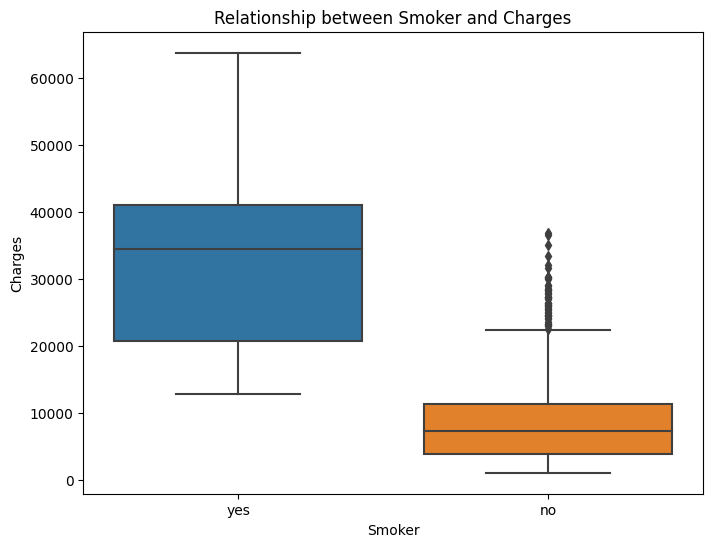

In [65]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='smoker', y='charges')
plt.title('Relationship between Smoker and Charges')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()

# Non-smokers generally pay less.

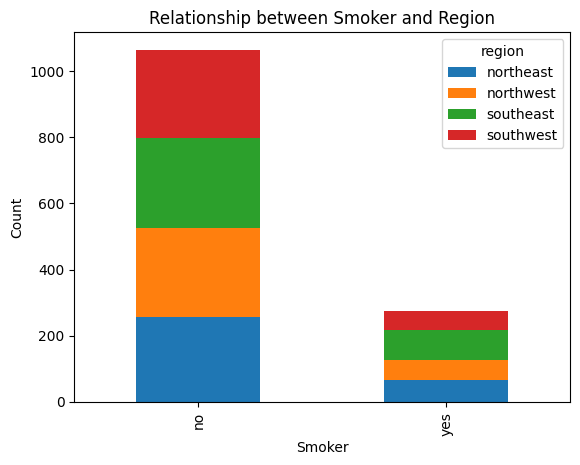

In [66]:
smoker_region = pd.crosstab(df['smoker'], df['region'])
smoker_region.plot(kind='bar', stacked=True)
plt.title('Relationship between Smoker and Region')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.show()

# While there is no abnormal situation, it can be said that those in the southeast region smoke slightly more, albeit with a small difference.

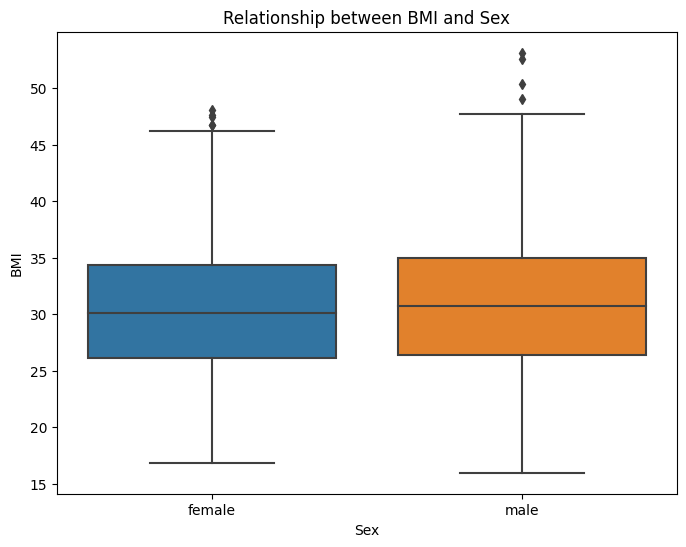

In [67]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sex', y='bmi')
plt.title('Relationship between BMI and Sex')
plt.xlabel('Sex')
plt.ylabel('BMI')
plt.show()

# There is no abnormal condition.

In [68]:
avg_children_by_region = df.groupby('region')['children'].mean()
max_children_region = avg_children_by_region.idxmax()
print(f'{avg_children_by_region}\n\nThe region with the most children: ---->', max_children_region)

region
northeast   1.046
northwest   1.148
southeast   1.049
southwest   1.142
Name: children, dtype: float64

The region with the most children: ----> northwest


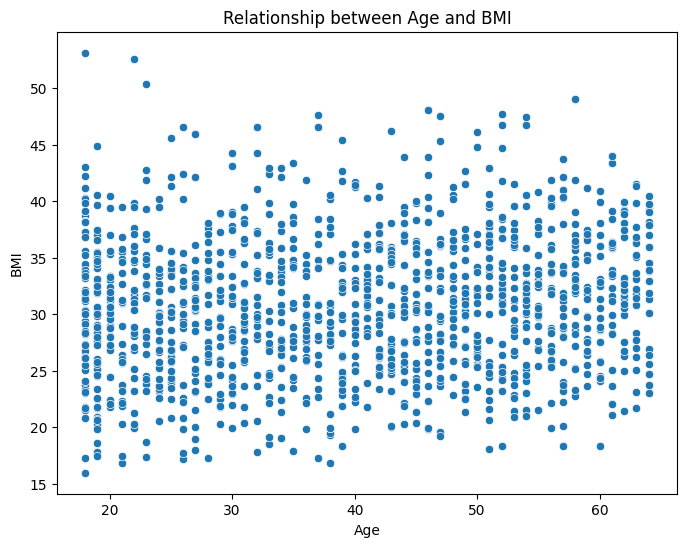

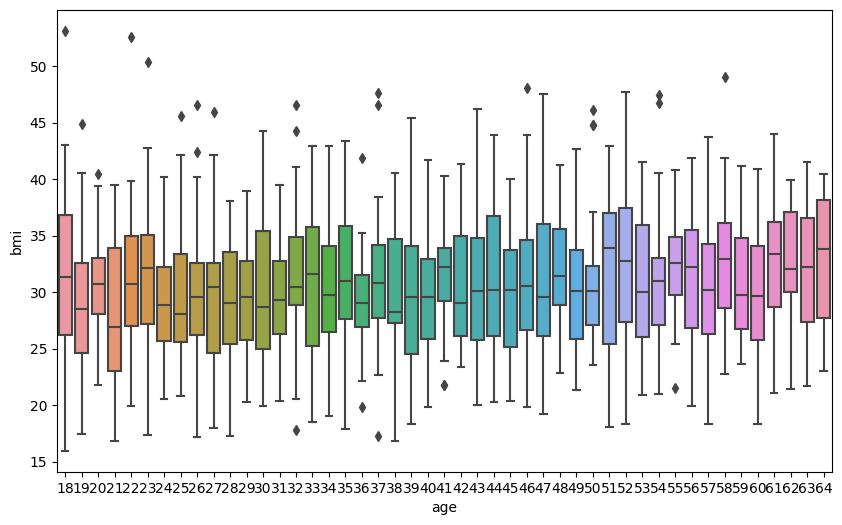

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='age', y='bmi')
plt.title('Relationship between Age and BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='age', y='bmi')
plt.show()

# Everything seems normal.

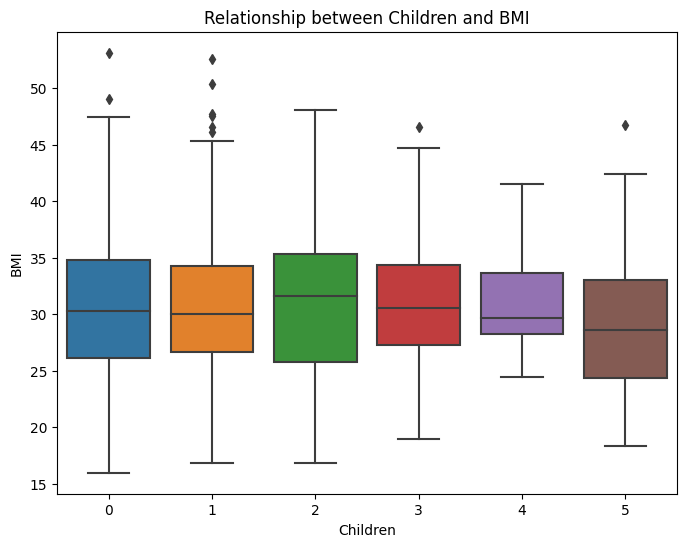

In [70]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='children', y='bmi')
plt.title('Relationship between Children and BMI')
plt.xlabel('Children')
plt.ylabel('BMI')
plt.show()

# There is no abnormal condition.

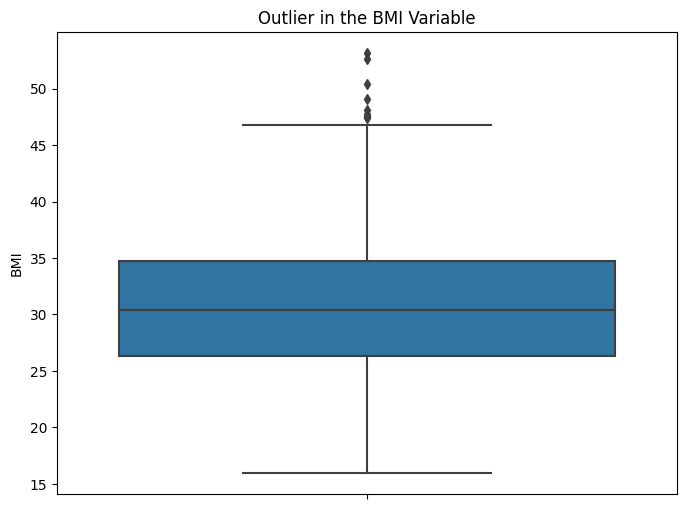

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='bmi')
plt.title('Outlier in the BMI Variable')
plt.ylabel('BMI')
plt.show()

# There are outliers.

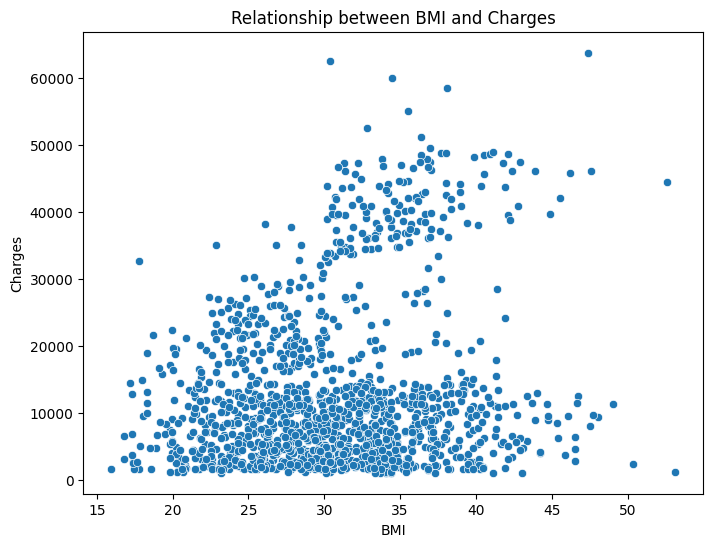

In [72]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='bmi', y='charges')
plt.title('Relationship between BMI and Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

# There seems to be a mild relationship.

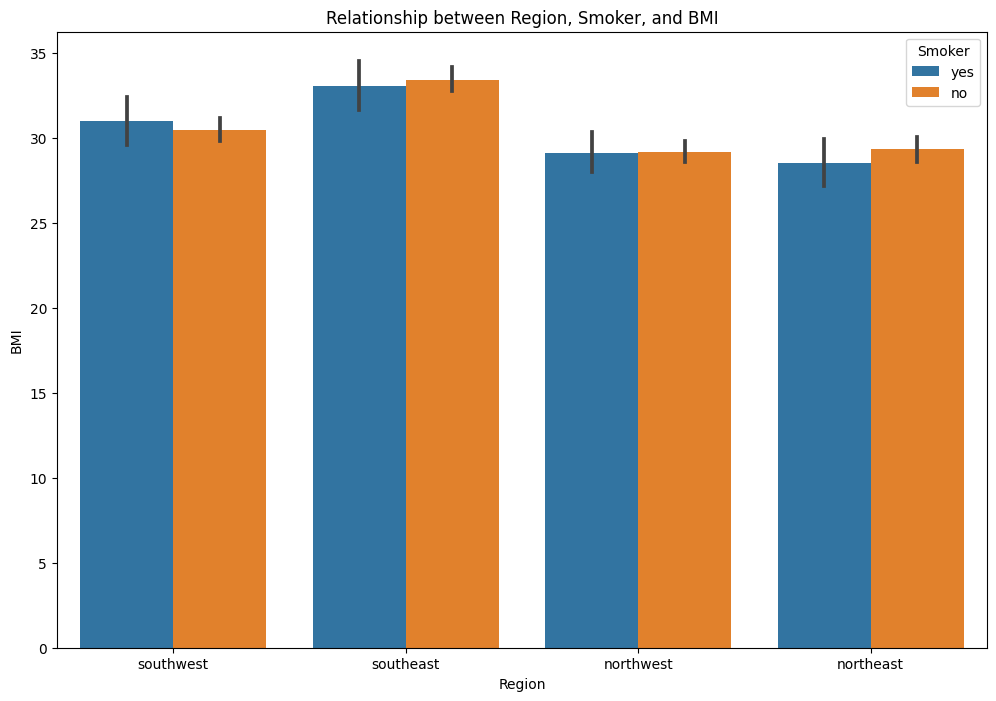

In [73]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='region', y='bmi', hue='smoker')
plt.title('Relationship between Region, Smoker, and BMI')
plt.xlabel('Region')
plt.ylabel('BMI')
plt.legend(title='Smoker')
plt.show()

# The southeastern region has higher BMI values independent of smoking.

## Data Preprocessing ##

In [74]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [75]:
cat_cols

['sex', 'smoker', 'region', 'children']

In [76]:
df = one_hot_encoder(df, cat_cols, drop_first= True)

In [77]:
df = df*1
df.head()

,age,bmi,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.924,0,1,0,0,1,0,0,0,0,0
1,18,33.770,1725.552,1,0,0,1,0,1,0,0,0,0
2,28,33.000,4449.462,1,0,0,1,0,0,0,1,0,0
3,33,22.705,21984.471,1,0,1,0,0,0,0,0,0,0
4,32,28.880,3866.855,1,0,1,0,0,0,0,0,0,0


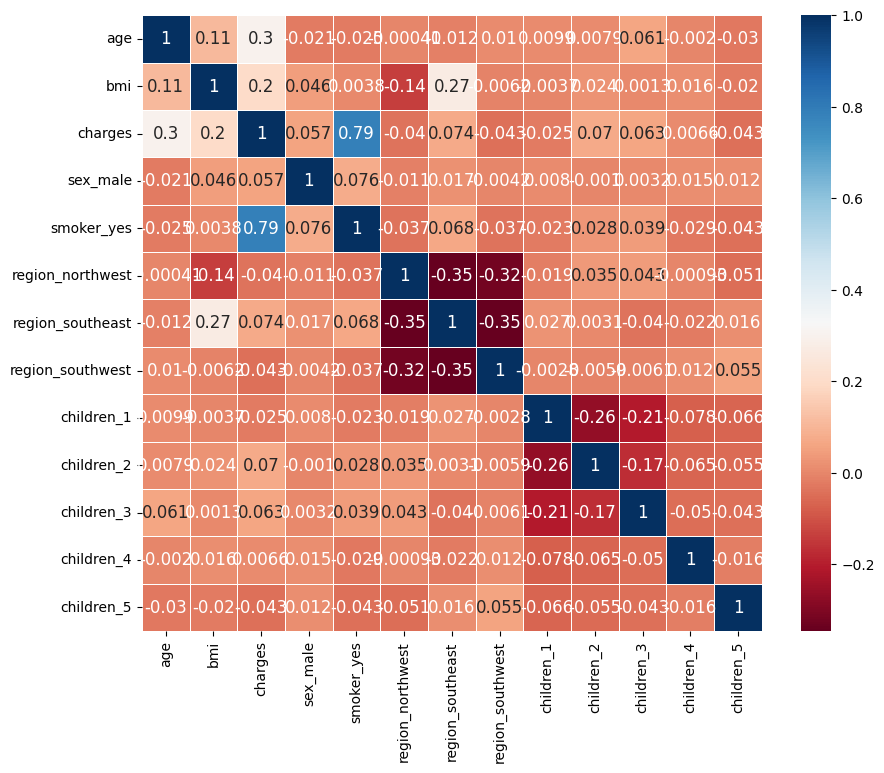

In [78]:
correlation_matrix(df, df.columns)

In [79]:
X,y = df.drop(["charges"], axis = 1), df["charges"] 

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## base models ##

In [81]:
def base_models(X, y, cv = 5, scoring="r2"):
    print("Base Models....")
    classifiers = [
        ("Gradient Boosting Regressor", GradientBoostingRegressor()),
        ("XGB Regressor", XGBRegressor()),
        ("Decision Tree Regressor", DecisionTreeRegressor()),
        ("Random Forest Regressor", RandomForestRegressor()),
        ("Linear Regression", LinearRegression()),
        ("Lasso Regression", Lasso())
    ]

    best_score = float("-inf")
    best_model_name = ""
    best_model = None

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        mean_score = cv_results['test_score'].mean()
        print(f"{scoring}: {round(mean_score, 4)} ({name}) ")

        if mean_score > best_score:
            best_score = mean_score
            best_model_name = name
            best_model = classifier

    print(f"\nModel with the highest {scoring} value: {best_model_name} ({best_score:.4f})")

    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y,y_pred)

    print("\nEvaluation metrics:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("r2:", r2)


In [82]:
base_models(X_scaled, y, scoring="r2")

Base Models....
r2: 0.8541 (Gradient Boosting Regressor) 
r2: 0.7944 (XGB Regressor) 
r2: 0.6748 (Decision Tree Regressor) 
r2: 0.8295 (Random Forest Regressor) 
r2: 0.7463 (Linear Regression) 
r2: 0.7463 (Lasso Regression) 

Model with the highest r2 value: Gradient Boosting Regressor (0.8541)

Evaluation metrics:
Mean Absolute Error (MAE): 2503.2318468401268
Mean Squared Error (MSE): 21130830.479051918
r2: 0.8558043430961003


## Hyper-parameter Optimizations ##

In [83]:

Gradient_Boosting_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

XGB_Regressor_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

Decision_Tree_params = {
        'max_depth': [3, 4, 5, None]
    }

Random_Forest_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, None]
    }

Lasso_Regression_params = {
    'alpha': [0.1, 1.0, 10.0]
    }

Linear_Regression_params = {}

classifiers = [
        ("Gradient Boosting Regressor", GradientBoostingRegressor(), Gradient_Boosting_params),
        ("XGB Regressor", XGBRegressor(), XGB_Regressor_params),
        ("Decision Tree Regressor", DecisionTreeRegressor(), Decision_Tree_params),
        ("Random Forest Regressor", RandomForestRegressor(), Random_Forest_params,),
        ("Linear Regression", LinearRegression(), Linear_Regression_params),
        ("Lasso Regression", Lasso(), Lasso_Regression_params)
        ]



In [84]:
def hyperparameter_optimization(X, y, cv=5, scoring="r2"):
    print("Hyperparameter Optimization....")
    best_models = {}
    best_score = float("-inf")
    best_model_name = ""
    
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        mean_score = round(cv_results['test_score'].mean(), 4)
        print(f"{scoring} (After): {mean_score}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

        if mean_score > best_score:
            best_score = mean_score
            best_model_name = name
            best_model = final_model

    print(f"\nModel with the highest {scoring} value: {best_model_name} ({best_score:.4f})")

    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y,y_pred)

    print("\nEvaluation metrics:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("r2:", r2)

    return best_models


In [85]:
hyperparameter_optimization(X_scaled, y, cv=5, scoring="r2")

Hyperparameter Optimization....
########## Gradient Boosting Regressor ##########
r2 (Before): 0.8542
r2 (After): 0.8557
Gradient Boosting Regressor best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

########## XGB Regressor ##########
r2 (Before): 0.7944
r2 (After): 0.8563
XGB Regressor best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

########## Decision Tree Regressor ##########
r2 (Before): 0.6864
r2 (After): 0.8454
Decision Tree Regressor best params: {'max_depth': 4}

########## Random Forest Regressor ##########
r2 (Before): 0.83
r2 (After): 0.8552
Random Forest Regressor best params: {'max_depth': 4, 'n_estimators': 300}

########## Linear Regression ##########
r2 (Before): 0.7463
r2 (After): 0.7463
Linear Regression best params: {}

########## Lasso Regression ##########
r2 (Before): 0.7463
r2 (After): 0.7463
Lasso Regression best params: {'alpha': 10.0}


Model with the highest r2 value: XGB Regressor (0.8563)

Evaluation metric

{}